In [45]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import superlearn_library as superlearn

unsup_datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'
sup_datapath = '../../mlrefined_datasets/superlearn_datasets/'

normalizers = unsuplib.normalizers
optimizers = optlib.optimizers
cost_lib = superlearn.cost_functions
classification_plotter = superlearn.classification_static_plotter.Visualizer();


# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Comparing modern convolutional architectures 

<figure>
    <img src= '../../mlrefined_images/convnet_images/CNN_architectures.png' width="120%"  height="auto" alt=""/>
</figure> 

### LeNet
Proposed in 1998 by LeCun et al.

Structurally consists of 2 conv layers + 2 fully connected layers with a total of ~50K tunable weights

Used tanh (in place of ReLU) as nonlinear activation

Trained on MNIST dataset consisting of 60K images of handwritten digits

### AlexNet
Proposed by Krizhevsky et al. in 2012

Structurally consists of 5 conv layers + 3 fully connected layers with a total of ~60M tunable weights

Used ReLU as nonlinear activation

Used drop-out to mitigate overfitting

Trained on ImageNet dataset consisting of ~15M images

Optimization tricks: mini-batch gradient descent, momentum trick, regularization 

### VGGNet
Proposed by Simonyan and Zisserman in 2014

Structurally consists of 14 conv layers + 3 fully connected layers with a total of ~140M tunable weights

Used ReLU as nonlinear activation

# Transfer Learning

- Modern CNNs can have tens or even hundreds of layers with hundreds of millions tunable weights

- Without large datsets (with millions of data points) training such architectures will lead to extreme overfitting.

- Additionally, training from scratch of such deep archtiectures require extensive computational resources and training time (e.g., AlexNet: two GPUs, 6 days, and VGGNet: four GPUs, 14 days).

In these case, i.e., when you have a smaller than ideal dataset and/or limited time to train a network from scratch, you can still leverage pre-trained models like AlexNet or VGGNet by 'transferring' some knowledge/information gained from these models to yours. This is typically called <strong>transfer learning</strong>.   

For instance, you can simply re-use these pre-trained models by keeping all their weights untouched except for the weights of the final layer which you learn using your own dataset. In other words, you only tune the weights $w_1$ through $w_B$ in your model 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

while using the features $f_1$ through $f_B$, as provided by deep CNN architectures.   

Depending on the size of your data, you may take this idea one step further and also learn some of the weights inside each $f$, usually those belonging to the later layers of the CNN architecture. Instead of initializing these weights randomly, they can be initialized with their optimal values according to the pre-trained model.  

# ZCA sphereing for image data

Press the button 'Toggle code' below to toggle code on and off for entire this presentation.

In [69]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is eåxported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

Previously we have seen two feature scaling schemes: <strong>standard normalization</strong> and <strong>PCA-sphereing</strong>.

Both help improve the contours of a cost function to allow gradient descent to converge much faster than it typically would otherwise.

### Standard normalization

Standard normalization includes subtracting off the mean and dividing by the standard deviation along each of its feature dimensions.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/standard_normal_only.png' width="200%"  height="auto" alt=""/>
</figure>

### Python implementation

In [57]:
# standard normalization function 
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer, inverse_normalizer

### Snapshot of MNIST dataset

In [58]:
# This code cell will not be shown in the HTML version of this notebook
# load data
from sklearn.datasets import fetch_mldata
MNIST = fetch_mldata('MNIST original')
x = MNIST.data.astype('float64')
y = np.reshape(MNIST.target, (-1, 1))
ind = np.random.permutation(len(y))
P = 70
x = x[ind[:P],:].T
y = y[ind[:P]]

<IPython.core.display.Javascript object>


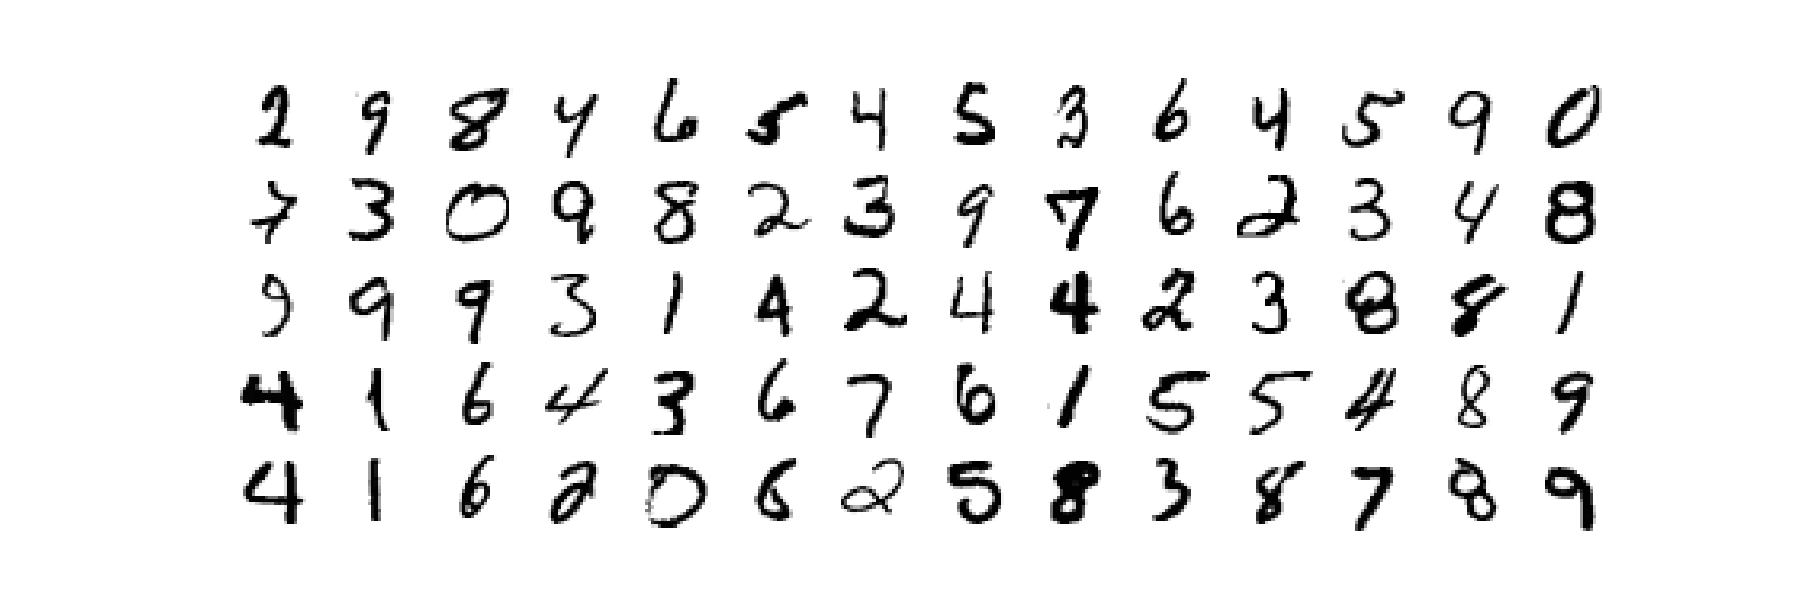

In [59]:
# plot a sample of the images
unsuplib.PCA_functionality.show_images(x)

### Standard normalization of MNIST 

<IPython.core.display.Javascript object>


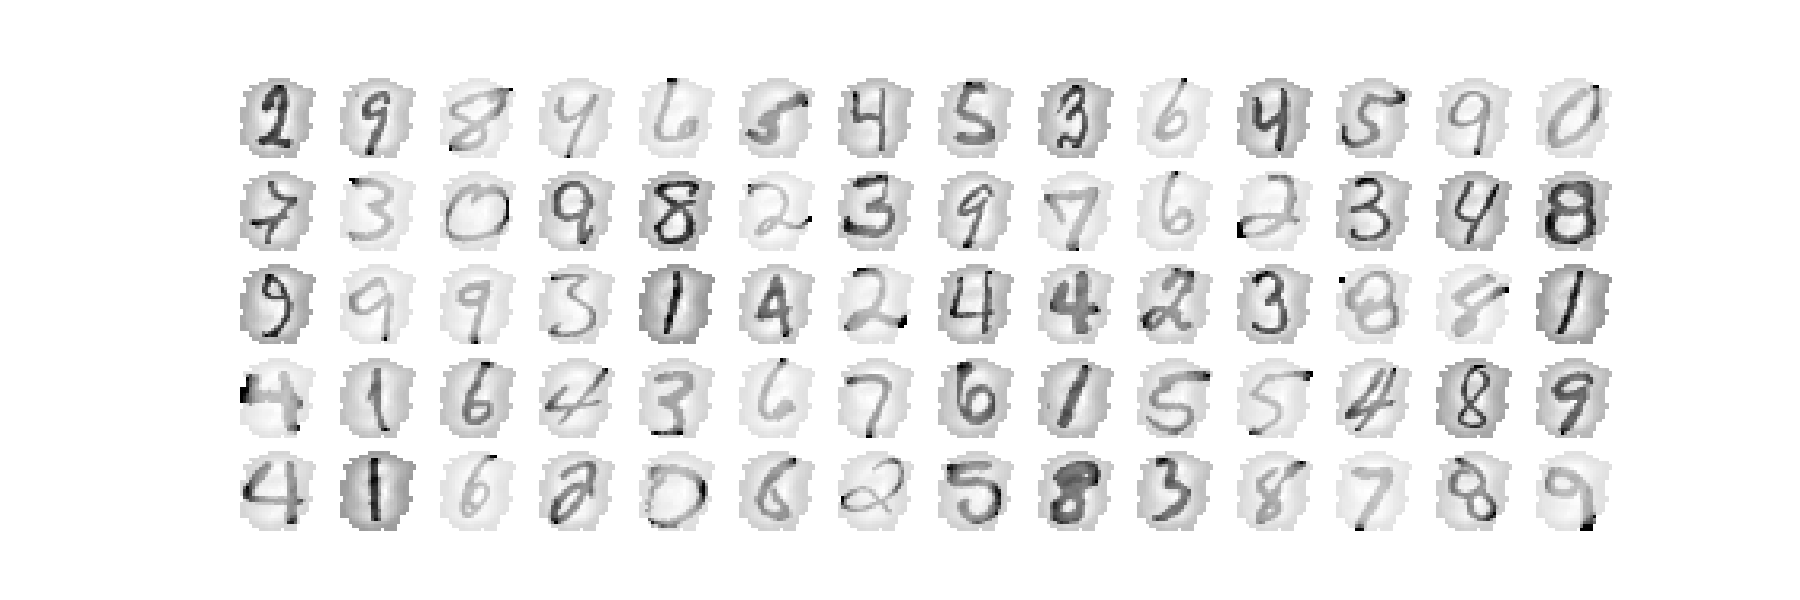

In [60]:
# standard normalize data
standard_func,inverse_standard = standard_normalizer(x)
x_standard = standard_func(x)

# plot standard-normalized data
unsuplib.PCA_functionality.show_images(x_standard)

### PCA sphereing

PCA sphereing has one more additional step, that is, rotating the data such that its principal components align with coordinate axes.  

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/standard_normal_vs_pca_sphereing.png' width="200%"  height="auto" alt=""/>
</figure>

This additional step helps better condition the cost function, leading to faster convergence of gradient descent. 

<figure>
    <img src= '../../mlrefined_images/unsupervised_images/standard_vs_sphereing_contours.png' width="90%"  height="auto" alt=""/>
</figure> 

### PCA-sphereing: how it is done

 - Denote $\frac{1}{P}\mathbf{X}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$ the regularized covariance matrix of this data.

- We can find ts eigenvalue/vector decomposition as $\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T +\lambda \mathbf{I}_{N\times N}= \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T$.

<figure>
    <img src= '../../mlrefined_images/unsupervised_images/pca_sphereing.png' width="90%"  height="auto" alt=""/>
</figure> 

### Python implementation

In [64]:
# compute eigendecomposition of data covariance matrix for PCA transformation
def PCA(x,**kwargs):
    # regularization parameter for numerical stability
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']

    # create the correlation matrix
    P = float(x.shape[1])
    Cov = 1/P*np.dot(x,x.T) + lam*np.eye(x.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    d,V = np.linalg.eigh(Cov)
    return d,V

# PCA-sphereing - use PCA to normalize input features
def PCA_sphereing(x,**kwargs):
    # Step 1: mean-center the data
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means

    # Step 2: compute pca transform on mean-centered data
    d,V = PCA(x_centered,**kwargs)

    # Step 3: divide off standard deviation of each (transformed) input, 
    # which are equal to the returned eigenvalues in 'd'.  
    stds = (d[:,np.newaxis])**(0.5)
    normalizer = lambda data: np.dot(V.T,data - x_means)/stds

    # create inverse normalizer
    inverse_normalizer = lambda data: np.dot(V,data*stds) + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

### PCA-sphereing of MNIST

<IPython.core.display.Javascript object>


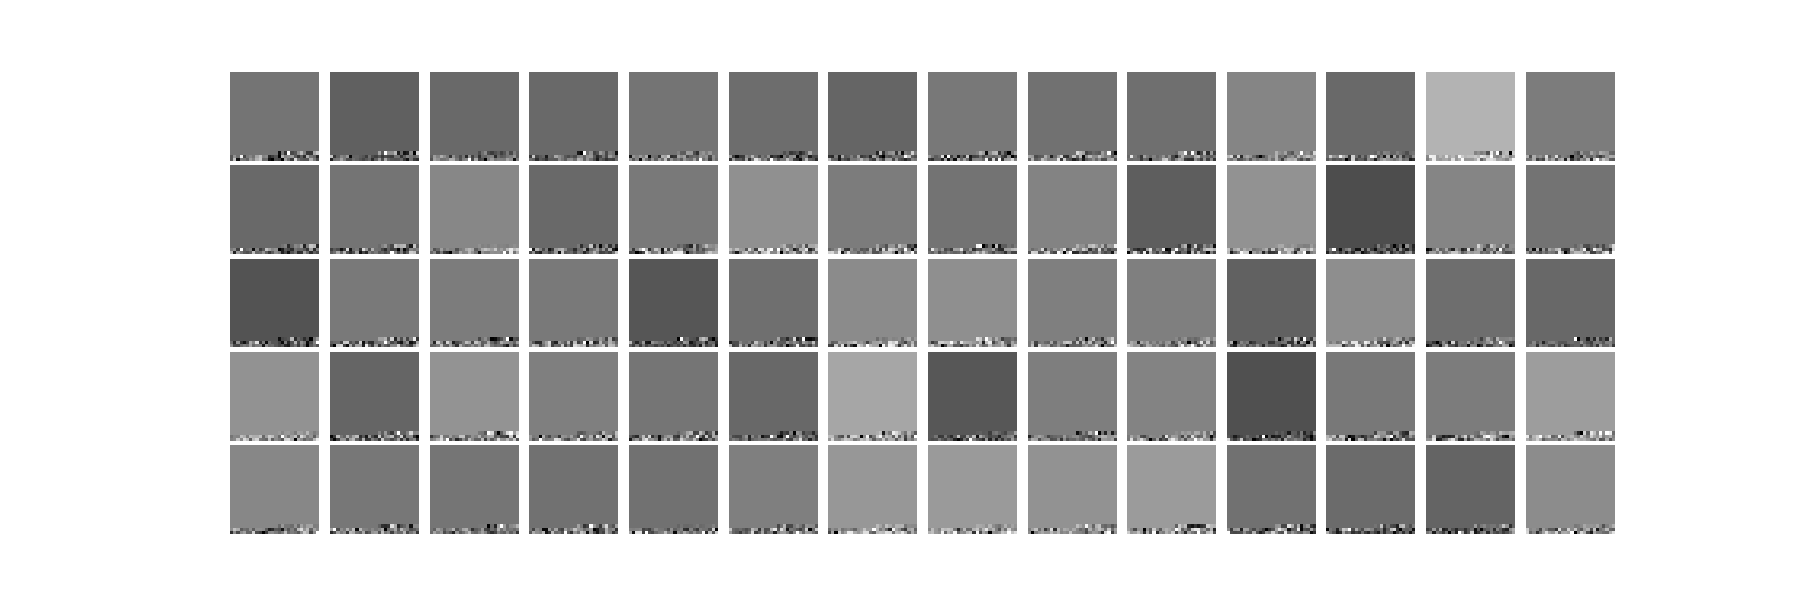

In [65]:
# create PCA sphereing normalizer and normalize data
pca_sphere,inverse_sphere = PCA_sphereing(x)
x_sphered = pca_sphere(x)

# plot PCA-sphered data
unsuplib.PCA_functionality.show_images(x_sphered)

The rotation utterly destroys the spatial correlation structure of our images. 

Why is that a problem? 

Because convolutional features require such structure.

What can we do if we would still like the added optimization-boosting benefit of PCA-sphereing normalization but do not want to destroy the spatial correlation of our input data?

We can simply rotate our dataset back to its original orientation after we finish sphereing it.

Since we know that its multiplication by $\mathbf{V}^T$ that produces the original rotation, multiplying by PCA-sphered data by $\left(\mathbf{V}^T\right)^{-1} = \mathbf{V}^{\,}$ will return the sphered data to its original orientation. This is called <strong>Zero-phase Component Analysis (ZCA)</strong>.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/zca_sphereing.png' width="110%"  height="auto" alt=""/>
</figure>

### Python implementation

In [67]:
# ZCA-sphereing - use ZCA to normalize input features
def ZCA_sphereing(x,**kwargs):
    # Step 1: mean-center the data
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means

    # Step 2: compute pca transform on mean-centered data
    d,V = PCA(x_centered,**kwargs)

    # Step 3: divide off standard deviation of each (transformed) input, 
    # which are equal to the returned eigenvalues in 'd'.  
    stds = (d[:,np.newaxis])**(0.5)
    normalizer = lambda data: np.dot(V, np.dot(V.T,data - x_means)/stds)

    # create inverse normalizer
    inverse_normalizer = lambda data: np.dot(V,np.dot(V.T,data)*stds) + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

### ZCA-sphereing of MNIST

<IPython.core.display.Javascript object>


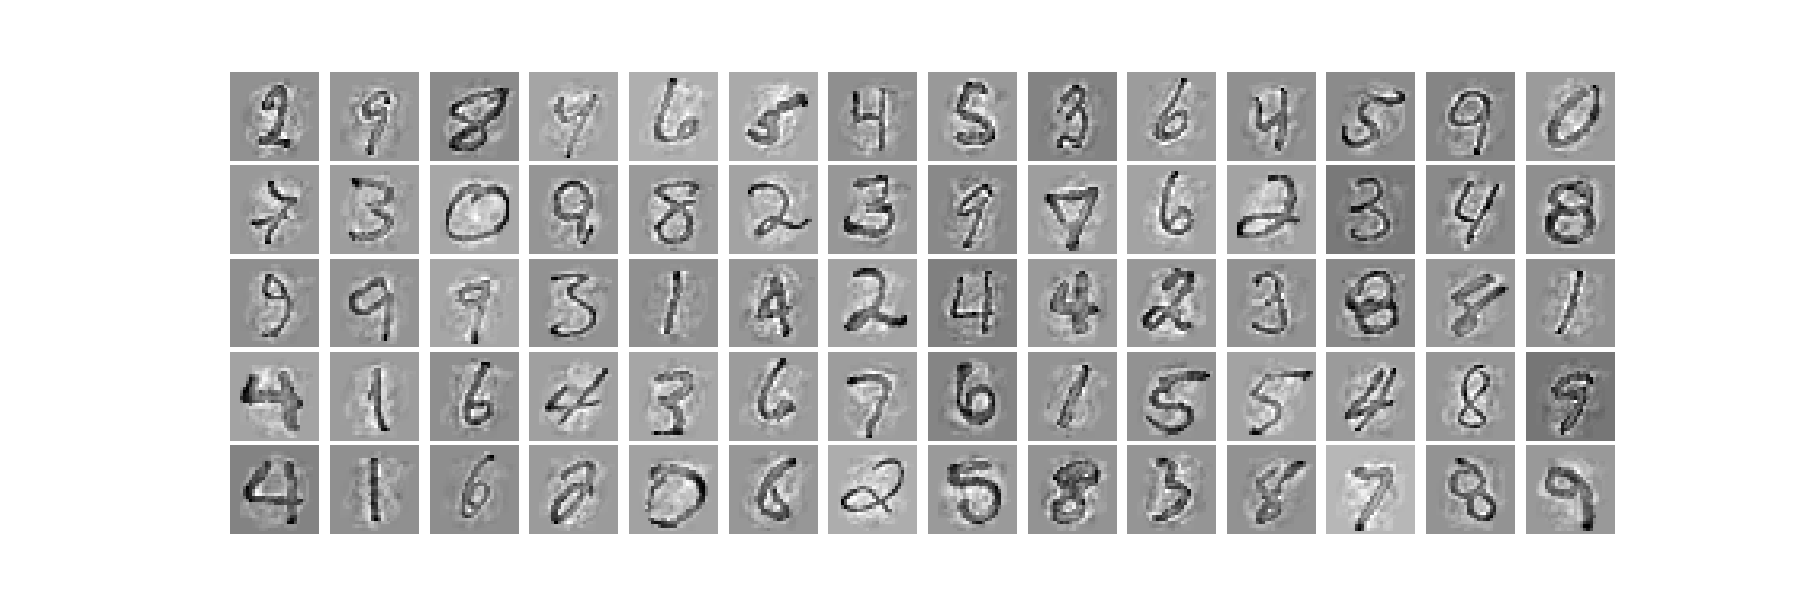

In [68]:
# create ZCA sphereing normalizer and normalize data
zca_sphere,inverse_sphere = ZCA_sphereing(x)
x_sphered = zca_sphere(x)

# plot ZCA-sphered data
unsuplib.PCA_functionality.show_images(x_sphered)